In [40]:
import os 
import datetime
from pathlib import Path, PurePath, PosixPath
from dotenv import load_dotenv, find_dotenv

basepath = Path(os.getcwd())
# make sure your working directory is the repository root.
if basepath.name != "idp-radio-1":
    os.chdir(basepath.parent.parent)
load_dotenv(find_dotenv())

%load_ext autoreload
%autoreload 2
os.getcwd()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'/srv/idp-radio-1'

In [41]:
import tensorflow as tf
import tensorflow.keras as keras
import pandas as pd
import numpy as np
from skimage.transform import resize
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras.callbacks import TensorBoard
from src.utils.save_model import save_model, model_set
from src.datasets.generator import ImageDataGenerator

In [9]:
# Load labels and split into training and valid

DATASET_FOLDER = Path(os.environ.get("CHEXPERT_DATASET_DIRECTORY"))

data = pd.read_csv(DATASET_FOLDER / 'train.csv')
data = data[data['Frontal/Lateral'].str.contains("Frontal")]
#data = data[:256]
data_train, data_val = train_test_split(data, test_size=0.2)

In [27]:
# create generators
columns = ['Cardiomegaly', 'Lung Opacity', 'Lung Lesion', 'Edema']
train_datagen = ImageDataGenerator(data_train, DATASET_FOLDER, columns, batch_size=8, dim=(270,270), augmentation="affine")
valid_datagen = ImageDataGenerator(data_train, DATASET_FOLDER, columns, batch_size=8, dim=(270,270), augmentation="eqhist")

In [ ]:
base_model = resnet_v2.ResNet152V2(include_top=False, weights='imagenet')

# add global pooling and dense output layer 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
prediction_layer = Dense(len(columns), activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=prediction_layer)

In [ ]:

# compile model
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
# fit model
num_epochs = 3
STEP_SIZE_TRAIN = len(data_train) // train_datagen.batch_size
STEP_SIZE_VALID = len(data_val) // valid_datagen.batch_size
result = model.fit_generator(generator=train_datagen,
                             steps_per_epoch=STEP_SIZE_TRAIN,
                             validation_data=valid_datagen,
                             validation_steps=STEP_SIZE_VALID,
                             epochs=num_epochs)

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
def plot_batch(generator, batchnum):
    plt.figure(figsize=(20, 10))
    i = 0
    for img in generator[batchnum][0]:
        plt.subplot(2, 4, i+1)
        # Plot the image
        plt.imshow(img)
        plt.axis('off')
        i += 1
    plt.show()

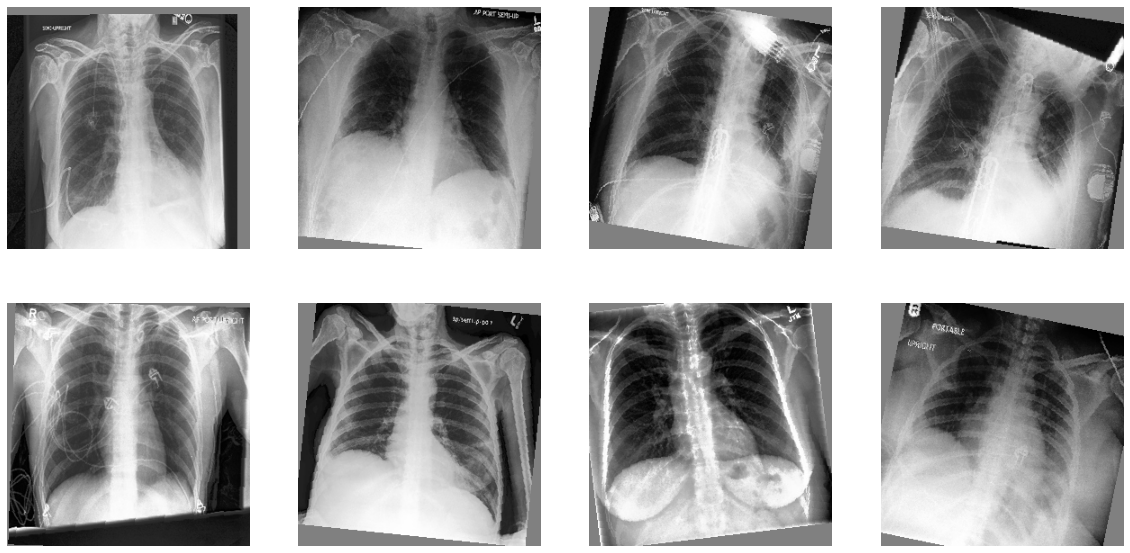

In [39]:
plot_batch(train_datagen, 0)

In [36]:
plot_batch(valid_datagen, 0)

NotImplementedError: No functional yet.

<Figure size 1440x720 with 0 Axes>